In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import h5py
import pickle

# Assuming the model and data loading utilities are available in the specified modules
from Dataloaders import StrakaBubble, StrakaBubbleDataset, StrakaBubblePlottingDataset
from CNOModule import CNO

# Set device for computation
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize dataset
test_dataset = StrakaBubbleDataset(which="test", training_samples=128, model_type="CNO", dt=60)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

/cluster/apps/nss/gcc-8.2.0/python/3.10.4/x86_64/lib64/python3.10/site-packages/xarray/backends/cfgrib_.py:27: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(


In [2]:


# # Path to the saved model
model_path = 'TrainedModels/CNO_straka_bubble_0_to_900/model.pkl'
# model_path = 'TrainedModels/CNO_poisson_paper/model.pkl'

# Load the entire model directly
model = torch.load(model_path, map_location=torch.device(device))
# model.eval()

In [39]:
# import torch
# import numpy as np
# from sklearn.metrics import mean_absolute_error

# def evaluate_model(model, data_loader, device):
#     model.eval()  # Set the model to evaluation mode
#     relative_errors = []
    
#     with torch.no_grad():  # No need to track gradients for validation data
#         for batch in data_loader:
#             for inputs, labels in batch:
#                 inputs, labels = inputs.to(device), labels.to(device)
#                 outputs = model(inputs)
#                 # Compute relative L1 error for each batch and collect
#                 relative_error = torch.mean(torch.abs(outputs - labels)) / torch.mean(torch.abs(labels))
#                 relative_errors.append(relative_error.item() * 100)  # Convert to percentage
            
#     # Calculate the average of relative errors across all batches
#     average_relative_error = np.mean(relative_errors)
#     print(f'Average Relative L1 Error: {average_relative_error:.2f}%')
    
#     return average_relative_error

# # Evaluate the model
# average_relative_error = evaluate_model(model, test_loader, device)


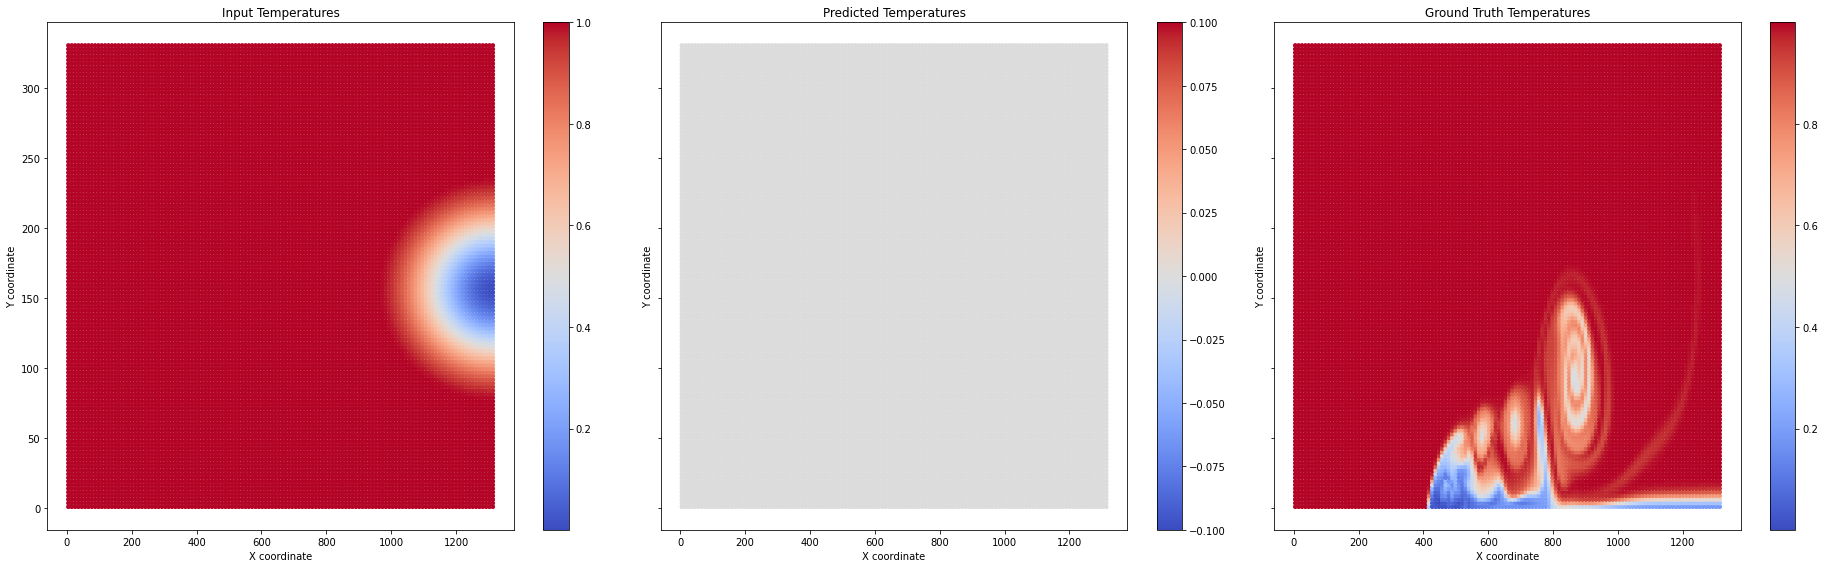

In [9]:
import matplotlib.pyplot as plt
import torch
import numpy as np


def plot_samples(data_loader, model, n, device, model_type, cmap='coolwarm', vmin=None, vmax=None):
    model.eval()
    with torch.no_grad():
        for i, batch in enumerate(data_loader):
            for inputs, outputs in batch:
                if i == n:
                    inputs, outputs = inputs.to(device), outputs.to(device)
                    
                    if model_type == "FNO":
                        inputs = inputs.permute(0,3,1,2)
                        outputs = outputs.permute(0,3,1,2)

                    # Correct data extraction and reshaping based on how your dataloader formats the batch
                    x_coords = inputs[0, 0, :, :].cpu().numpy().flatten()  # Assuming first channel is x-coordinates
                    z_coords = inputs[0, 1, :, :].cpu().numpy().flatten()  # Assuming second channel is y-coordinates
                    temp_values_t_in = inputs[0, 4, :, :].cpu().numpy().flatten()  # Assuming fifth channel is temperature
                    temp_values_t_out = outputs[0, 0, :, :].cpu().numpy().flatten()  # Assuming outputs are correctly squeezed
                    
                    # predictions = model(inputs).squeeze(1)  # Ensure predictions match dimensions
                    # if autoreg:
                    #     inputs_running = inputs.clone()
                    #     for _ in range(15):
                    #         predictions = model(inputs_running)
                    #         inputs_running[0, :, :, 4] = predictions[0, :, :, 0]
                    # else:
                    #     predictions = model(inputs)
                    # predictions = predictions.squeeze(1)
                    # predictions = predictions.cpu().numpy().flatten()

                    fig, axes = plt.subplots(1, 3, figsize=(26, 8), sharex=True, sharey=True)

                    # Input temperature distribution
                    sc1 = axes[0].scatter(x_coords, z_coords, c=temp_values_t_in, cmap=cmap, vmin=vmin, vmax=vmax, s=13)
                    axes[0].set_title("Input Temperatures")
                    axes[0].set_xlabel('X coordinate')
                    axes[0].set_ylabel('Y coordinate')
                    fig.colorbar(sc1, ax=axes[0])

                    # Prediction temperature distribution
                    sc2 = axes[1].scatter(x_coords, z_coords, c=np.zeros_like(temp_values_t_in), cmap=cmap, vmin=vmin, vmax=vmax, s=13)
                    axes[1].set_title("Predicted Temperatures")
                    axes[1].set_xlabel('X coordinate')
                    axes[1].set_ylabel('Y coordinate')
                    fig.colorbar(sc2, ax=axes[1])

                    # Output temperature distribution
                    sc3 = axes[2].scatter(x_coords, z_coords, c=temp_values_t_out, cmap=cmap, vmin=vmin, vmax=vmax, s=13)
                    axes[2].set_title("Ground Truth Temperatures")
                    axes[2].set_xlabel('X coordinate')
                    axes[2].set_ylabel('Y coordinate')
                    fig.colorbar(sc3, ax=axes[2])

                    plt.tight_layout()
                    plt.show()
                    break

# Example usage
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_type = "FNO"
test_loader = DataLoader(StrakaBubblePlottingDataset(which="training", training_samples=256, model_type=model_type, t_in=0, t_out=900), batch_size=1, shuffle=False)
# test_loader = DataLoader(StrakaBubbleDataset(which="test", training_samples=128, model_type="CNO", dt=60), batch_size=1, shuffle=False)
plot_samples(test_loader, model, n=0, device=device, model_type=model_type, cmap='coolwarm', vmin=None, vmax=None)


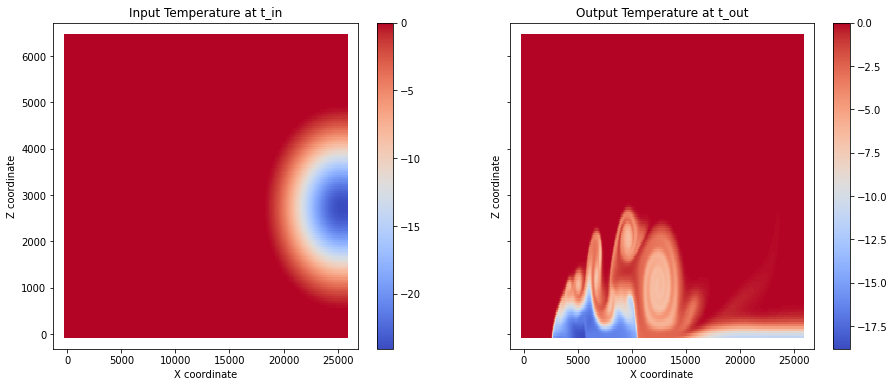

In [45]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

def load_and_plot_data(file_path, t_in_index, t_out_index):
    # Load the dataset
    ds = xr.open_mfdataset(file_path + "1023" + "_fields.nc")
    
    # Extract temperatures at specified time indices
    temp_values_t_in = ds['temperature_anomaly'].isel(t=t_in_index).values
    temp_values_t_out = ds['temperature_anomaly'].isel(t=t_out_index).values
    
    # Extract spatial coordinates
    x_values = ds.coords['x'].values
    z_values = ds.coords['z'].values
    
    # Create meshgrid for coordinates
    x_grid, z_grid = np.meshgrid(x_values, z_values, indexing='ij')
    
    # Flatten the arrays for plotting
    x_flat = x_grid.flatten()
    z_flat = z_grid.flatten()
    temp_in_flat = temp_values_t_in.flatten()
    temp_out_flat = temp_values_t_out.flatten()
    
    # Plotting
    fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

    sc1 = axes[0].scatter(x_flat, z_flat, c=temp_in_flat, cmap='coolwarm', marker='s')
    axes[0].set_title('Input Temperature at t_in')
    axes[0].set_xlabel('X coordinate')
    axes[0].set_ylabel('Z coordinate')
    fig.colorbar(sc1, ax=axes[0], orientation='vertical')

    sc2 = axes[1].scatter(x_flat, z_flat, c=temp_out_flat, cmap='coolwarm', marker='s')
    axes[1].set_title('Output Temperature at t_out')
    axes[1].set_xlabel('X coordinate')
    axes[1].set_ylabel('Z coordinate')
    fig.colorbar(sc2, ax=axes[1], orientation='vertical')

    plt.show()

# Parameters
file_path = "/cluster/work/math/camlab-data/data_dana/4-Straka_vdIC_uvDT_timeseries_1024samples/samples/data/sample_"  # Update this path
t_in_index = 0  # Example time index for input
t_out_index = 15  # Example time index for output

load_and_plot_data(file_path, t_in_index, t_out_index)


In [270]:
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import Dataset

class StrakaBubbleDataset(Dataset):
    def __init__(self, which="training", nf=0, training_samples = 750, s=512, in_dist = True, t_in=0, t_out=300):
        
        self.t_in = t_in
        self.t_out = t_out
        assert self.t_in in 60 * np.array(range(16))
        assert self.t_out in 60 * np.array(range(16))
        assert self.t_in < self.t_out
        self.s = s
        self.in_dist = in_dist
        #The file:
        
        self.file_data = "/cluster/work/math/camlab-data/data_dana/4-Straka_vdIC_uvDT_timeseries_1024samples/samples/data/sample_"
        
        # self.reader = xr.open_mfdataset() 
        
        self.N_max = 1024

        self.n_val  = 128
        self.n_test = 128
        
        if which == "training":
            self.length = training_samples
            self.start = 0
        elif which == "validation":
            self.length = self.n_val
            self.start = self.N_max - self.n_val - self.n_test
        elif which == "test":
            self.length = self.n_test
            self.start = self.N_max  - self.n_test
        
        
    def __len__(self):
        return self.length

    def __getitem__(self, index):
        
        ds = xr.open_mfdataset(self.file_data + str(index + self.start) + "_fields.nc")
        # Extracting u values at t=0 and t=300
        temp_values_t_in = ds['temperature_anomaly'].isel(t=self.t_in//60).values  # u values at t=t_in
        temp_values_t_out = ds['temperature_anomaly'].isel(t=self.t_out//60).values  # u values at t=t_out
        x_values = ds.coords['x'].values  # x coordinates
        z_values = ds.coords['z'].values  # z coordinates
        x_grid, z_grid = np.meshgrid(x_values, z_values, indexing='ij')
        viscosity = ds.attrs["VISCOSITY"]
        diffusivity = ds.attrs["DIFFUSIVITY"]
        viscosity = viscosity * np.ones_like(x_grid)
        diffusivity = diffusivity * np.ones_like(x_grid)
        
        # Convert to PyTorch tensors
        inputs = torch.tensor(np.stack([x_grid, z_grid, viscosity, diffusivity, temp_values_t_in], axis=0), dtype=torch.float32)
        labels = torch.tensor(temp_values_t_out, dtype=torch.float32)
        
        
        # Resize and downsample
        inputs = torch.stack([resize_and_downsample(inputs[i, :, :], (512, 128), (128, 128)) for i in range(inputs.shape[0])])
        labels = resize_and_downsample(labels.squeeze(0), (512, 128), (128, 128))
        # labels = labels.unsqueeze(0).transpose(1, 2)
        
        # Normalising
        inputs = (inputs - temp_values_t_in.min())/(temp_values_t_in.max() - temp_values_t_in.min())
        # inputs = (inputs - temp_values_t0.mean())/temp_values_t0.std()
        labels = (labels - temp_values_t_out.min())/(temp_values_t_out.max() - temp_values_t_out.min())
        # labels = (labels - temp_values_t300.mean())/temp_values_t300.std()
        
        
        inputs = inputs.permute(1, 2, 0)
        labels = labels.unsqueeze(-1)
        
        print("HERE")

        return inputs, labels
    
    
class StrakaBubble:
    def __init__(self, network_properties, device, batch_size, training_samples, in_dist = True, t_in=0, t_out=300):
        
        if "in_size" in network_properties:
            self.in_size = network_properties["in_size"]
            s = self.in_size
        else:
            self.in_size = 64
            s = 64

        network_properties = default_param(network_properties)
        
        retrain = network_properties["retrain"]
        torch.manual_seed(retrain)
        
        #----------------------------------------------------------------------
        
        self.model = FNO2d(fno_architecture = network_properties, 
                            in_channels = 5, 
                            out_channels = 1, 
                            device=device)        
        
        #----------------------------------------------------------------------
        
        #Change number of workers accoirding to your preference
        num_workers = 0
        self.train_loader = DataLoader(StrakaBubbleDataset("training", training_samples, t_in=t_in, t_out=t_out), batch_size=batch_size, shuffle=True, num_workers=8)
        self.val_loader = DataLoader(StrakaBubbleDataset("validation", training_samples, t_in=t_in, t_out=t_out), batch_size=batch_size, shuffle=False, num_workers=8)
        self.test_loader = DataLoader(StrakaBubbleDataset("test", training_samples, t_in=t_in, t_out=t_out), batch_size=batch_size, shuffle=False, num_workers=num_workers)

HERE


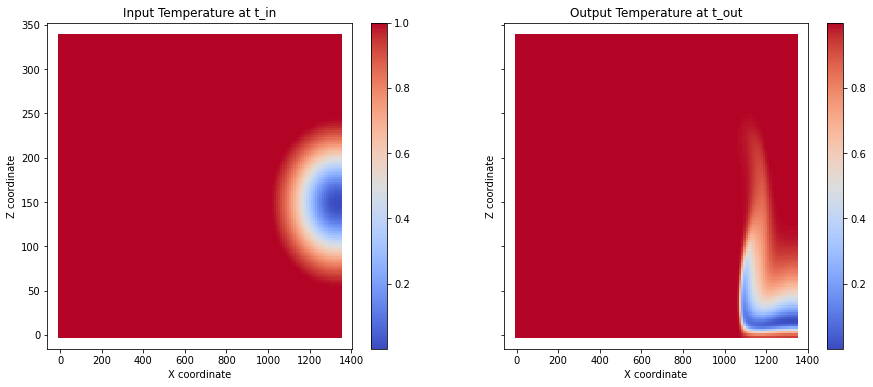

In [273]:
import torch
from torch.utils.data import DataLoader

def plot_first_batch_from_dataloader(dataloader):
    # Fetch the first batch
    for inputs, outputs in dataloader:
        x_coords = inputs[0, :, :, 0].cpu().numpy()  # X coordinates
        z_coords = inputs[0, :, :, 1].cpu().numpy()  # Z coordinates
        temp_values_t_in = inputs[0, :, :, 4].cpu().numpy()  # Input temperatures
        temp_values_t_out = outputs[0, :, :, 0].cpu().numpy()  # Output temperatures
        
        # Plotting
        fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=True)
        
        sc1 = axes[0].scatter(x_coords.flatten(), z_coords.flatten(), c=temp_values_t_in.flatten(), cmap='coolwarm', marker='s')
        axes[0].set_title('Input Temperature at t_in')
        axes[0].set_xlabel('X coordinate')
        axes[0].set_ylabel('Z coordinate')
        fig.colorbar(sc1, ax=axes[0], orientation='vertical')

        sc2 = axes[1].scatter(x_coords.flatten(), z_coords.flatten(), c=temp_values_t_out.flatten(), cmap='coolwarm', marker='s')
        axes[1].set_title('Output Temperature at t_out')
        axes[1].set_xlabel('X coordinate')
        axes[1].set_ylabel('Z coordinate')
        fig.colorbar(sc2, ax=axes[1], orientation='vertical')

        plt.show()
        
        break  # Exit after the first batch

# Assuming your dataset and DataLoader setup
dataset = StrakaBubbleDataset(which="test", training_samples=128, t_in=0, t_out=300)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)  # Set shuffle=False to always get the same first item

# Now using the plotting function
plot_first_batch_from_dataloader(dataloader)


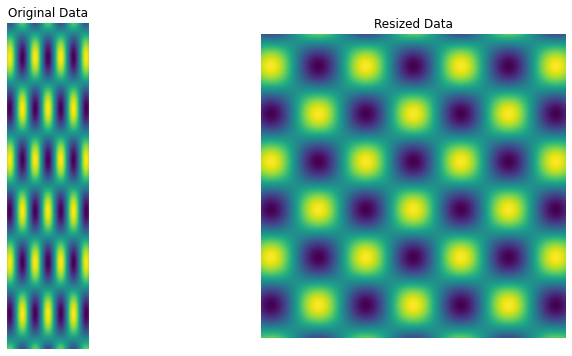

In [272]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

def resize_and_downsample(u, original_shape=(512, 128), target_shape=(128, 128)):
    """
    Resize and downsample the input tensor to a new shape using bilinear interpolation.
    Args:
    - u (torch.Tensor): The input tensor to be resized. Expected to have shape (H, W).
    - original_shape (tuple): The original shape of the input tensor (H, W).
    - target_shape (tuple): The desired shape (H, W) after resizing.
    Returns:
    - torch.Tensor: The resized tensor with shape (1, H, W) where 1 is the channel dimension.
    """
    # Ensure the input tensor is a float tensor (required for interpolate)
    if not u.is_floating_point():
        u = u.float()
    
    # Reshape the input to add a channel dimension (C=1)
    if u.dim() == 2:
        u = u.unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions
    elif u.dim() == 3:
        u = u.unsqueeze(1)  # Add a channel dimension

    # Use interpolate to resize
    resized_u = F.interpolate(u, size=target_shape, mode='bilinear', align_corners=False)
    # Remove batch and channel dimensions for output
    resized_u = resized_u.squeeze(0).squeeze(0)
    
    return resized_u

# Simulating temperature data
original_shape = (512, 128)
target_shape = (128, 128)

# Create a synthetic temperature field
x = torch.linspace(-10, 10, original_shape[0])
y = torch.linspace(-10, 10, original_shape[1])
grid_x, grid_y = torch.meshgrid(x, y)
data = torch.sin(grid_x) * torch.cos(grid_y)

# Resize and downsample
resized_data = resize_and_downsample(data, original_shape=original_shape, target_shape=target_shape)

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(data.numpy(), cmap='viridis')
axes[0].set_title('Original Data')
axes[0].axis('off')

axes[1].imshow(resized_data.numpy(), cmap='viridis')
axes[1].set_title('Resized Data')
axes[1].axis('off')

plt.show()


In [262]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

def resize_and_downsample(u, original_shape=(512, 128), target_shape=(128, 128)):
    if not u.is_floating_point():
        u = u.float()
    if u.dim() == 2:
        u = u.unsqueeze(0).unsqueeze(0)
    resized_u = F.interpolate(u, size=target_shape, mode='bilinear', align_corners=False)
    return resized_u.squeeze(0).squeeze(0)

# Create mock data for inputs and labels
np.random.seed(0)
x_values = np.linspace(0, 1, 512)
z_values = np.linspace(0, 1, 128)
x_grid, z_grid = np.meshgrid(x_values, z_values, indexing='ij')
viscosity = np.ones_like(x_grid)
diffusivity = np.ones_like(x_grid)
temperature = np.sin(x_grid * 2 * np.pi) * np.cos(z_grid * 2 * np.pi)  # Some pattern

# Convert to PyTorch tensors
inputs = torch.tensor(np.stack([x_grid.flatten(), z_grid.flatten(), viscosity.flatten(), diffusivity.flatten(), temperature.flatten()], axis=1), dtype=torch.float32).reshape(5, 512, 128)
labels = torch.tensor(temperature.flatten(), dtype=torch.float32).reshape(1, 512, 128)

plot_data(temperature, inputs[-1, :, :], "test")

# Apply resizing and downsampling
inputs_resized = torch.stack([resize_and_downsample(inputs[i, :, :], (512, 128), (128, 128)) for i in range(inputs.shape[0])])
labels_resized = resize_and_downsample(labels.squeeze(0), (512, 128), (128, 128))

# Plotting function
def plot_data(original, resized, title):
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    cax1 = ax[0].imshow(original, cmap='coolwarm', origin='lower')
    fig.colorbar(cax1, ax=ax[0])
    ax[0].set_title('Original ' + title)
    
    cax2 = ax[1].imshow(resized, cmap='coolwarm', origin='lower')
    fig.colorbar(cax2, ax=ax[1])
    ax[1].set_title('Resized ' + title)
    
    plt.show()

# Display the original and resized data
plot_data(temperature, labels_resized.numpy(), "Labels")
plot_data(temperature, inputs_resized[-1].numpy(), "Inputs")  # Display the temperature channel
plot_data(temperature, resize_and_downsample(inputs[-1, :, :], (512, 128), (128, 128)), "Only Temp")


TypeError: plot_data() takes 2 positional arguments but 3 were given

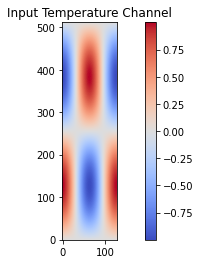

/scratch/tmp.57925694.jaking/ipykernel_98731/2175633702.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image_tensor = torch.tensor(image, dtype=torch.float32).unsqueeze(0).unsqueeze(0)


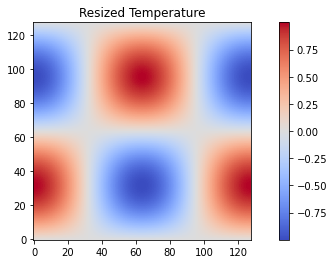

In [263]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def plot_data(data, title):
    plt.figure(figsize=(10, 4))
    plt.imshow(data, cmap='coolwarm', origin='lower')
    plt.colorbar()
    plt.title(title)
    plt.show()

# Grid data generation
x_values = np.linspace(0, 1, 512)
z_values = np.linspace(0, 1, 128)
x_grid, z_grid = np.meshgrid(x_values, z_values, indexing='ij')
viscosity = np.ones_like(x_grid)
diffusivity = np.ones_like(x_grid)
temperature = np.sin(x_grid * 2 * np.pi) * np.cos(z_grid * 2 * np.pi)

# Direct conversion to torch.Tensor without reshaping
inputs = torch.tensor([x_grid, z_grid, viscosity, diffusivity, temperature], dtype=torch.float32)
labels = torch.tensor(temperature, dtype=torch.float32).unsqueeze(0)  # Keeping the single channel

# Example to plot one channel (temperature)
plot_data(inputs[-1, :, :].numpy(), "Input Temperature Channel")

# If resizing is necessary, directly apply it to 2D slices
import torch.nn.functional as F

def resize_and_downsample(image, target_shape=(128, 128)):
    image_tensor = torch.tensor(image, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    resized_image = F.interpolate(image_tensor, size=target_shape, mode='bilinear', align_corners=False)
    return resized_image.squeeze(0).squeeze(0)

resized_temperature = resize_and_downsample(inputs[-1, :, :], (128, 128))
plot_data(resized_temperature.numpy(), "Resized Temperature")


In [264]:
import matplotlib.pyplot as plt
import numpy as np
for inputs, outputs in dataloader:
        x_coords = inputs[0, :, :, 0].cpu().numpy()  # X coordinates
        z_coords = inputs[0, :, :, 1].cpu().numpy()  # Z coordinates
        temp_values_t_in = inputs[0, :, :, 4].cpu().numpy()  # Input temperatures
        temp_values_t_out = outputs[0, :, :, 0].cpu().numpy()  # Output temperatures
        break

def plot_temperature(data, title="Temperature"):
    x_values = np.linspace(0, 1, data.shape[0])
    z_values = np.linspace(0, 1, data.shape[1])
    plt.figure(figsize=(10, 4))
    plt.imshow(data, extent=[x_values.min(), x_values.max(), z_values.min(), z_values.max()], origin='lower')
    plt.colorbar()
    plt.title(title)
    plt.xlabel('X coordinate')
    plt.ylabel('Z coordinate')
    plt.show()

# Assuming temp_values_t_in is loaded as in your dataloader snippet
plot_temperature(temp_values_t_in, "Original Input Temperature")
def resize_and_downsample(u, target_shape=(128, 128)):
    if not u.is_floating_point():
        u = u.to(torch.float32)
    u = u.unsqueeze(0).unsqueeze(0)  # Shape: [1, 1, H, W]
    resized_u = F.interpolate(u, size=target_shape, mode='bilinear', align_corners=False)
    return resized_u.squeeze(0).squeeze(0)  # Shape: [H, W]

# Testing the resizing on mock data
mock_data = torch.sin(torch.linspace(0, 2 * np.pi, 512)).unsqueeze(0).repeat(128, 1)  # Sinusoidal pattern
resized_mock_data = resize_and_downsample(mock_data)
plot_temperature(mock_data.numpy(), "Before Resizing")
plot_temperature(resized_mock_data.numpy(), "After Resizing")


TypeError: resize_and_downsample() takes from 1 to 2 positional arguments but 3 were given